## Differenece From Baseline - stimuli Histogram

In [118]:
import os
import re
from typing import Dict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import mne
import numpy as np
import scipy.stats as sp_stats
from joblib import Parallel, delayed
from NirsLabProject.config.paths import Paths

from NirsLabProject.utils import general_utils as utils
from NirsLabProject.config.consts import *

from NirsLabProject.utils import general_utils as utils
from NirsLabProject.config.consts import *
from NirsLabProject.config.subject import Subject
from NirsLabProject.utils.group_spikes import group_spikes
from NirsLabProject.utils import plotting

In [60]:
subjects = [Subject(d, True) for d in os.listdir(Paths.products_data_dir_path) if d.startswith('p')]
subjects = filter(lambda subj: subj.stimuli_project, subjects)
subjects = filter(lambda subj: os.path.exists(subj.paths.subject_flat_features_path), subjects)
subjects = list(subjects)

In [101]:
baseline_diff = lambda a,b: ((b-a) / max(b, a)) * 100
list_avarage = lambda l: sum(l) / len(l) if len(l) > 0 else 0

For every feature (amplitude, spatial spread of multi channel group event) we calculate:
- for every block (stimuli, pause)
    - for every channel the avarage difference from baseline block
histogram of the the avarage diffrences of all the channels of all subjects

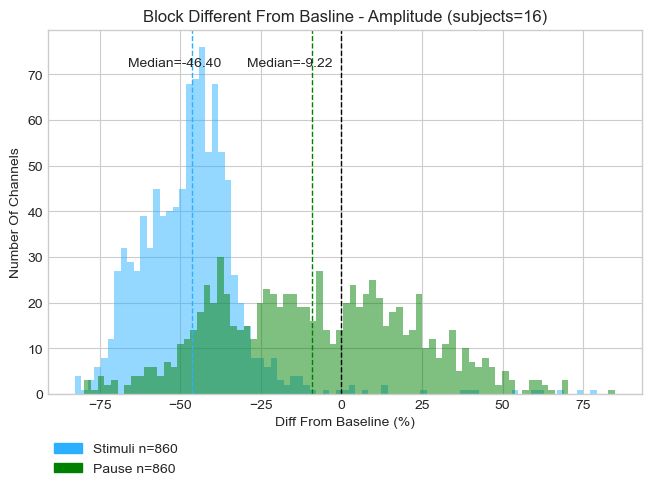

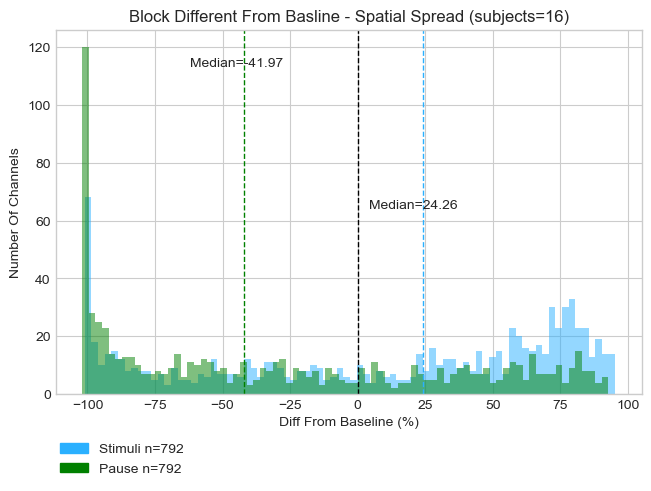

In [163]:


def validate(channels_to_fetures, block_feature):
    count = 0
    for channel, data in channels_to_fetures.items():
        count += len(data)
    assert block_feature.shape[0] == count

features_to_plot = {
    'Amplitude': AMPLITUDE_INDEX,
    'Spatial Spread': GROUP_EVENT_SPATIAL_SPREAD_INDEX
}

subject_s = Subject(STIMULI_PROJECT_INTERSUBJECTS_SUBJECT_NAME, True)
histogrmas_path =  os.path.join(
        subject_s.paths.subject_stimuli_effects_plots_dir_path,
        'histograms'
)
not os.path.exists(histogrmas_path) and  os.makedirs(histogrmas_path)

blocks = ['stimuli', 'pause']

for feature_name, feature_index in features_to_plot.items():
    channel_basline_diff = {
        k:[] for k in blocks
    }
    for subj in subjects:
        subj_features = np.load(subj.paths.subject_flat_features_path)

        group_ids = subj_features[:, GROUP_INDEX]
        unique_indices = np.unique(group_ids, return_index=True)[1]
        unique_group_subj_features = subj_features[unique_indices]

        if not os.path.exists(subj.paths.subject_sleep_scoring_path):
            continue
        
        for block in blocks:
            #  if group feature we don't need more than one representative
            if GROUP_INDEX <= feature_index <= GROUP_EVENT_SPATIAL_SPREAD_INDEX:
                group_ids = subj_features[:, GROUP_INDEX]
                unique_indices = np.unique(group_ids, return_index=True)[1]
                unique_group_subj_features = subj_features[unique_indices]
                before, stim_block, pause_block, _, _ = utils.stimuli_effects(subj, unique_group_subj_features)
            else:
                before, stim_block, pause_block, _, _ = utils.stimuli_effects(subj, subj_features)

            baseline_mean = np.mean(before[:, feature_index])
            block_to_comapre = stim_block if block == 'stimuli' else pause_block
            channels, _ = np.unique(block_to_comapre[:,CHANNEL_INDEX], return_inverse=True)
            channel_blocks_values = {channel: [] for channel in channels}
            for spike in block_to_comapre:
                channel_blocks_values[spike[CHANNEL_INDEX]].append(spike[feature_index])
            validate(channel_blocks_values, block_to_comapre)

            for channel, features in channel_blocks_values.items():
                channel_basline_diff[block].append(
                    baseline_diff(
                        baseline_mean,
                        list_avarage(features),
                    )
                )
                
    # Plot the histogram
    legend_settings = [
        {
            'color': '#2ab0ff',
            'label': 'Stimuli'
        },
        {
            'color': 'green',
            'label': 'Pause'
        }
    ]
    fig = plt.figure(layout='constrained')
    ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
    for i, block in enumerate(channel_basline_diff.keys()):
        diffs = channel_basline_diff[block]
        hist, edges = np.histogram(diffs, bins=20)
        median = np.median(diffs)

        plt.hist(diffs, bins=80, facecolor = legend_settings[i]['color'], edgecolor='None', linewidth=0.5, alpha = 0.5)
        plt.axvline(median, color=legend_settings[i]['color'], linestyle='dashed', linewidth=1)
        plt.text(median-20, plt.ylim()[-1]*0.9, f'Median={median:.2f}')
        plt.style.use('seaborn-whitegrid')
    legend = [
        mpatches.Patch(color=settings['color'], label=f"{settings['label']} n={len(diffs)}")
        for settings in legend_settings
    ]
    plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
    ax.legend(handles=legend, bbox_to_anchor=(0.24, -0.1))                                                
    title = f'Block Different From Basline - {feature_name}'
    plt.title(f'{title} (subjects={len(subjects)})')
    plt.xlabel('Diff From Baseline (%)')
    plt.ylabel('Number Of Channels')
    plt.savefig(
        os.path.join(
            histogrmas_path,
            f'{title}.png'
        ),
        dpi=1000
    )
